## Name: Shreyan Chakraborty
## Roll no: MDS202237

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Part 1


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


In [ ]:
# Check if GPU is available
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [ ]:
# Set up parameters
batch_size = 32
img_height = 256  # updated to match your image size
img_width = 256   # updated to match your image size

# Set paths to datasets
base_dir = '/content/drive/MyDrive/Applied ML/data'
chicken_dir = f'{base_dir}/chicken'  # specific path to chickens
duck_dir = f'{base_dir}/duck'        # specific path to ducks

# Create ImageDataGenerator for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)  # using 20% of the data for validation

# Prepare train and validation datasets
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')


Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [ ]:
# Load MobileNetV2 pre-trained model
with tf.device('/device:GPU:0'):
    base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                             include_top=False,
                             weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    # Create a new model on top
    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer=Adam(lr=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Summary of the model
    model.summary()


9406464/9406464 [==============================] - 0s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 81920)             0         
                                                                 
 dense (Dense)               (None, 128)               10485888  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 12744001 (48.61 MB)
Trainable params: 10486017 (40.00 MB)
Non-trainable params: 2257984 (8.61 MB)
__________

In [ ]:
# Train the model with GPU
with tf.device('/device:GPU:0'):
    epochs = 10
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        epochs=epochs)


Epoch 1/10
5/5 [==============================] - 43s 8s/step - loss: 8.0588 - accuracy: 0.5875 - val_loss: 10.2329 - val_accuracy: 0.7500
Epoch 2/10
5/5 [==============================] - 4s 936ms/step - loss: 8.8731 - accuracy: 0.7250 - val_loss: 8.6434 - val_accuracy: 0.6875
Epoch 3/10
5/5 [==============================] - 6s 1s/step - loss: 2.9174 - accuracy: 0.8687 - val_loss: 3.0481 - val_accuracy: 0.9062
Epoch 4/10
5/5 [==============================] - 4s 851ms/step - loss: 5.2077 - accuracy: 0.8562 - val_loss: 5.0633 - val_accuracy: 0.9375
Epoch 5/10
5/5 [==============================] - 4s 863ms/step - loss: 0.9557 - accuracy: 0.9500 - val_loss: 0.9502 - val_accuracy: 0.8750
Epoch 6/10
5/5 [==============================] - 6s 1s/step - loss: 2.4484 - accuracy: 0.8687 - val_loss: 3.2374 - val_accuracy: 0.8125
Epoch 7/10
5/5 [==============================] - 4s 835ms/step - loss: 0.7088 - accuracy: 0.9500 - val_loss: 3.8079 - val_accuracy: 0.9375
Epoch 8/10
5/5 [===========

In [ ]:
# Predict on the validation set
val_images, val_labels = next(validation_generator)
predictions = model.predict(val_images)
predicted_classes = [1 if prob > 0.5 else 0 for prob in predictions]

# Generate classification report
print(classification_report(val_labels, predicted_classes, target_names=['Chicken', 'Duck']))


1/1 [==============================] - 1s 904ms/step
              precision    recall  f1-score   support

     Chicken       0.94      0.94      0.94        17
        Duck       0.93      0.93      0.93        15

    accuracy                           0.94        32
   macro avg       0.94      0.94      0.94        32
weighted avg       0.94      0.94      0.94        32



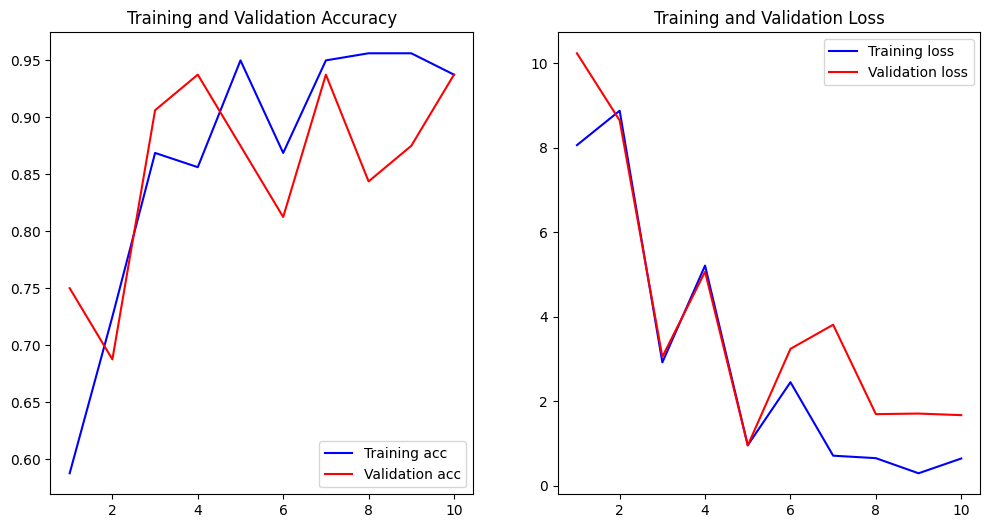

In [ ]:
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_training(history)
